# Predicting Death from AIDS Clinical Trials Group Study 175

In [1]:
# Dependencies
!pip install ucimlrepo

## Libraries

In [2]:
# Loading libraries
from ucimlrepo import fetch_ucirepo

import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTENC
from scipy.stats import zscore

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix

import random
random.seed(42)

## UCI Dataset

In [3]:
# Get AIDS dataset
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890) 

X = aids_clinical_trials_group_study_175.data.features 
y = aids_clinical_trials_group_study_175.data.targets

# Exploratory Data Analysis

## Dataset Head

In [4]:
# Features head
X.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,0,1,0,1,0,422,477,566,324
1,1002,3,61,49.4424,0,0,0,90,0,1,...,0,1,3,0,1,0,162,218,392,564
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,1,3,0,1,1,326,274,2063,1893
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,1,3,0,1,0,287,394,1590,966
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,1,3,0,0,0,504,353,870,782


In [5]:
# Target head
y.head()

,cid
0,0
1,1
2,0
3,0
4,0


1 means they died during a window of time, 0 means they did not.

## Missing Values

In [6]:
# Missing values
X.isna().sum()

time       0
trt        0
age        0
wtkg       0
hemo       0
homo       0
drugs      0
karnof     0
oprior     0
z30        0
zprior     0
preanti    0
race       0
gender     0
str2       0
strat      0
symptom    0
treat      0
offtrt     0
cd40       0
cd420      0
cd80       0
cd820      0
dtype: int64

No missing values! Woo!

## Feature Types

In [7]:
# Feature types
X.dtypes

time         int64
trt          int64
age          int64
wtkg       float64
hemo         int64
homo         int64
drugs        int64
karnof       int64
oprior       int64
z30          int64
zprior       int64
preanti      int64
race         int64
gender       int64
str2         int64
strat        int64
symptom      int64
treat        int64
offtrt       int64
cd40         int64
cd420        int64
cd80         int64
cd820        int64
dtype: object

All features are represented numerically, but some are categories. The only non-categorical columns are time, age, wtkg, karnof, preanti, cd40, cd420, cd80, and cd820.

## Dataset Dimensions

In [8]:
# Shapes
print(X.shape)
print(y.shape)

(2139, 23)
(2139, 1)


There are 2,139 rows with 23 features and 1 target.

## Categorical and Numeric Columns

In [9]:
# Categorical and numeric column names
num_cols = ["time", "age", "wtkg", "karnof", "preanti", "cd40", "cd420", "cd80", "cd820"]
cat_cols = [i for i in X.columns if i not in num_cols]

In [10]:
# Number of unique values in the categorical features
X[cat_cols].nunique()

trt        4
hemo       2
homo       2
drugs      2
oprior     2
z30        2
zprior     1
race       2
gender     2
str2       2
strat      3
symptom    2
treat      2
offtrt     2
dtype: int64

## Descriptive Statistics of Numeric Features

In [11]:
# Descriptive statistics of numeric features
X[num_cols].describe()

,time,age,wtkg,karnof,preanti,cd40,cd420,cd80,cd820
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,35.248247,75.125311,95.446470,379.175783,350.501169,371.307153,986.627396,935.369799
std,292.274324,8.709026,13.263164,5.900985,468.657526,118.573863,144.634909,480.197750,444.976051
min,14.000000,12.000000,31.000000,70.000000,0.000000,0.000000,49.000000,40.000000,124.000000
25%,727.000000,29.000000,66.679200,90.000000,0.000000,263.500000,269.000000,654.000000,631.500000
50%,997.000000,34.000000,74.390400,100.000000,142.000000,340.000000,353.000000,893.000000,865.000000
75%,1091.000000,40.000000,82.555200,100.000000,739.500000,423.000000,460.000000,1207.000000,1146.500000
max,1231.000000,70.000000,159.939360,100.000000,2851.000000,1199.000000,1119.000000,5011.000000,6035.000000


A few columns could have skewed data.

## Pairplot for Correlation and Skewness

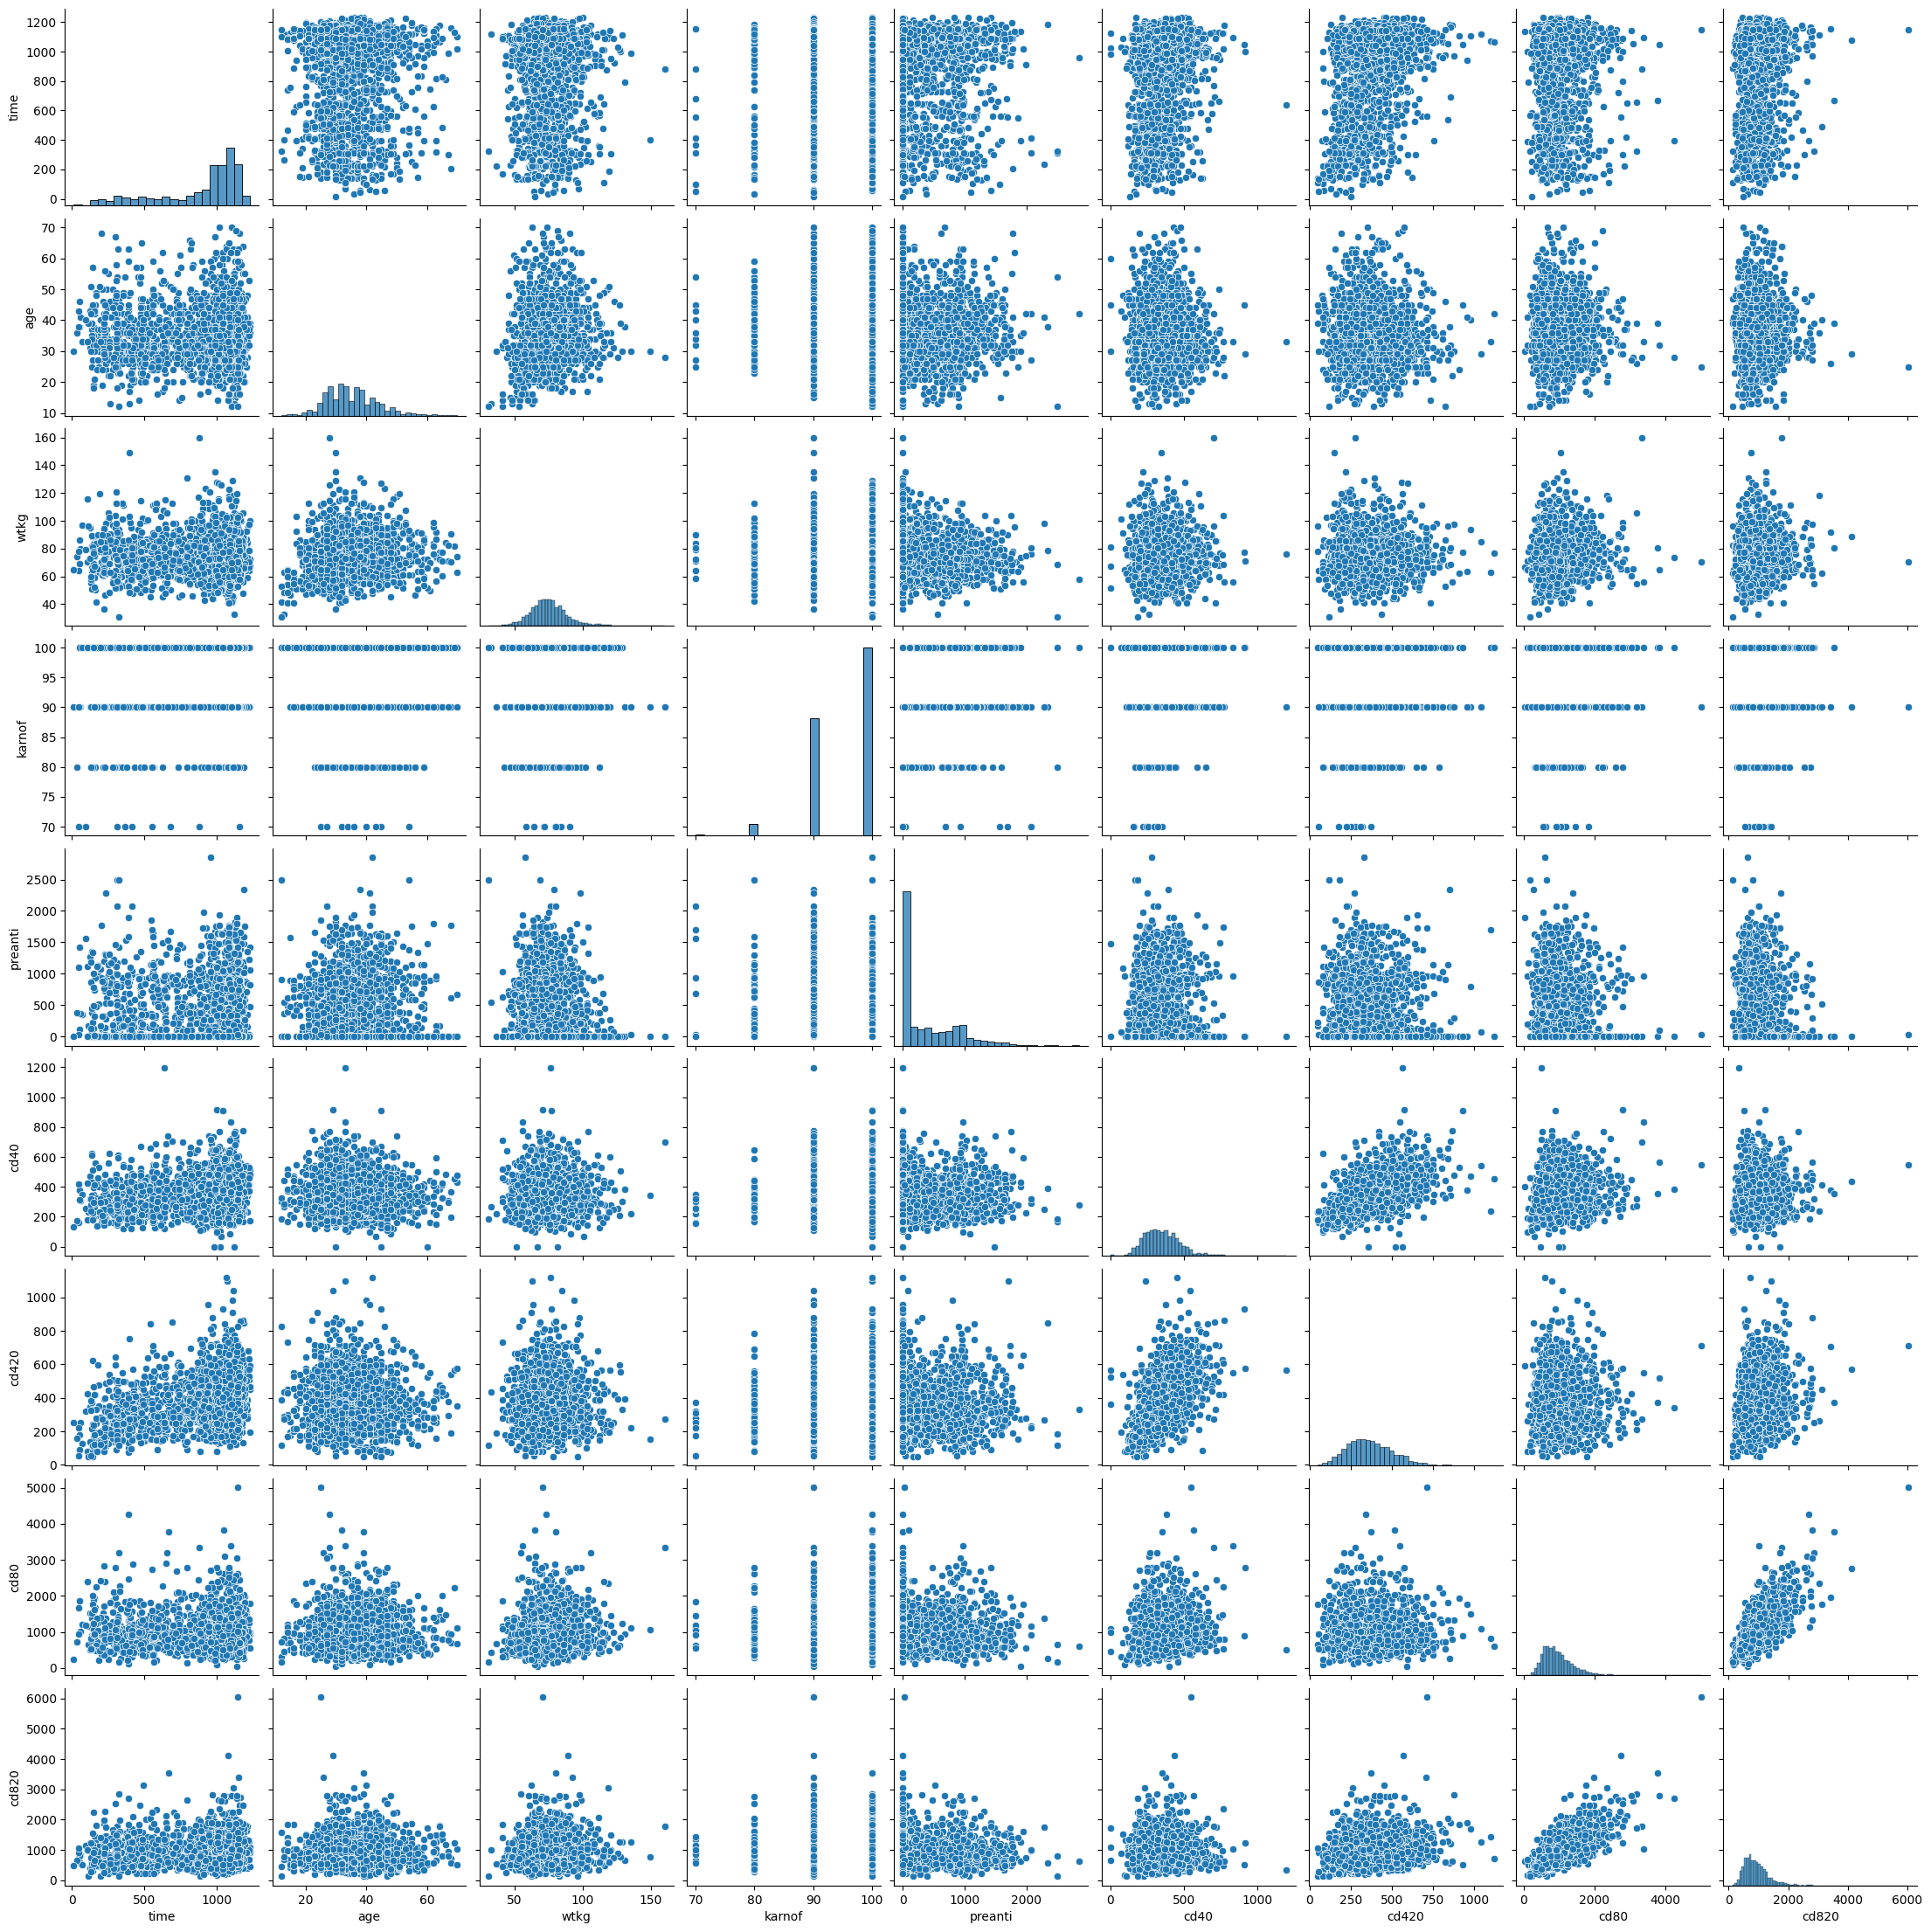

In [12]:
# Pairplot of numeric features
import warnings
warnings.filterwarnings('ignore', message='use_inf_as_na option is deprecated')

sns.pairplot(X[num_cols])
plt.show()

Based on the histograms along the diagonal, we can see that time and karnof are skewed to the left, and preanti is skewed to the right.

## Feature Class Distributions

In [13]:
# Class distributions for the features
for column in X[cat_cols].columns:
    # Calculate value counts and percentages
    value_counts = X[column].value_counts().sort_index()
    percentages = X[column].value_counts(normalize=True).sort_index() * 100
        
    # Combine counts and percentages
    distribution = pd.DataFrame({
        'Count': value_counts,
        'Percentage': percentages
    })
        
    print(f"\n{column}:")
    for idx, row in distribution.iterrows():
        print(f"    {idx}: {row['Count']} ({row['Percentage']:.1f}%)")

# and now for the target
value_counts = y["cid"].value_counts().sort_index()
percentages = y["cid"].value_counts(normalize=True).sort_index() * 100
    
distribution = pd.DataFrame({
    'Count': value_counts,
    'Percentage': percentages
})
    
print("\ncid:")
for idx, row in distribution.iterrows():
    print(f"    {idx}: {row['Count']} ({row['Percentage']:.1f}%)")


trt:
    0: 532.0 (24.9%)
    1: 522.0 (24.4%)
    2: 524.0 (24.5%)
    3: 561.0 (26.2%)

hemo:
    0: 1959.0 (91.6%)
    1: 180.0 (8.4%)

homo:
    0: 725.0 (33.9%)
    1: 1414.0 (66.1%)

drugs:
    0: 1858.0 (86.9%)
    1: 281.0 (13.1%)

oprior:
    0: 2092.0 (97.8%)
    1: 47.0 (2.2%)

z30:
    0: 962.0 (45.0%)
    1: 1177.0 (55.0%)

zprior:
    1: 2139.0 (100.0%)

race:
    0: 1522.0 (71.2%)
    1: 617.0 (28.8%)

gender:
    0: 368.0 (17.2%)
    1: 1771.0 (82.8%)

str2:
    0: 886.0 (41.4%)
    1: 1253.0 (58.6%)

strat:
    1: 886.0 (41.4%)
    2: 410.0 (19.2%)
    3: 843.0 (39.4%)

symptom:
    0: 1769.0 (82.7%)
    1: 370.0 (17.3%)

treat:
    0: 532.0 (24.9%)
    1: 1607.0 (75.1%)

offtrt:
    0: 1363.0 (63.7%)
    1: 776.0 (36.3%)

cid:
    0: 1618.0 (75.6%)
    1: 521.0 (24.4%)


We can see that the only features that don't have harsh class imbalances are trt, z30, and zprior (only 1 class). The target, cid, has a big class imbalance of 3:1.

## Multicollinearity

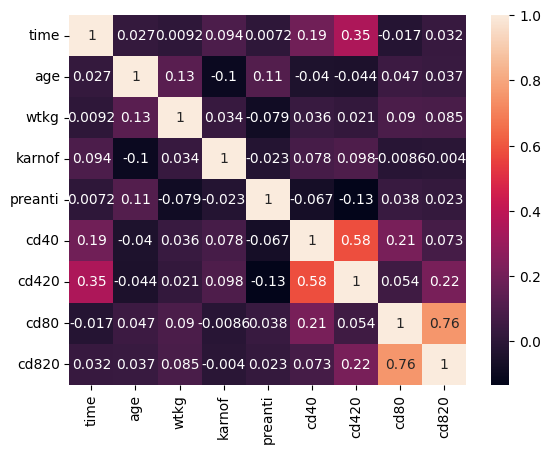

In [14]:
# Checking for multicollinearity
sns.heatmap(X[num_cols].corr(), annot=True)
plt.show()

We can see cd420 and cd40 have a correlation of 0.58, however cd80 and cd820 have a correlation of 0.76, which is very high. This makes sense, because cd420 and cd820 are both the cd40 and cd80 features at 20 +/- 5 weeks, respectively. We could later remove cd420 and cd820, but this is a decision that might need a little more information first.

## Feature Importance

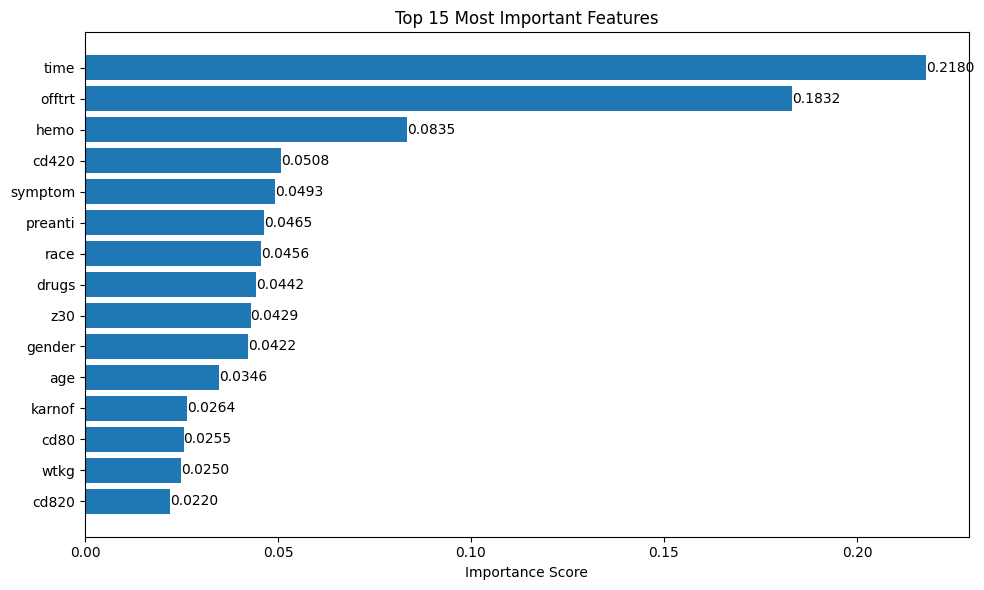

In [15]:
# Feature importance
xgb = XGBClassifier()
xgb.fit(X,y)

importances = xgb.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X.columns,  
    'importance': importances
})

top_features = feature_importance_df.sort_values('importance', ascending=True).tail(15)
top_feature_names = top_features['feature'].tolist()

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_features['importance'])

plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features')

for i, v in enumerate(top_features['importance']):
    plt.text(v, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

In [16]:
# New categorical and numeric column names
num_cols = ['cd820', 'wtkg', 'cd80', 'karnof', 'age', 'preanti', 'cd420', 'time']
cat_cols = [i for i in X[top_feature_names].columns if i not in num_cols]

# Feature Engineering

## Train/Test Split

In [17]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X[top_feature_names], y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

## Synthetic Minority Oversampling Technique (SMOTE) for Target

In [18]:
# Using SMOTENC to balance the target
smotenc = SMOTENC(categorical_features=cat_cols)
X_train_resampled, y_train_resampled = smotenc.fit_resample(X_train, y_train)

print(X_train_resampled.shape)
print(y_train_resampled.shape)

(2358, 15)
(2358, 1)


# Model Training

## Cross Validation for Model Selection

In [19]:
# Cross validation

lr = LogisticRegression()
cat = CatBoostClassifier(verbose = 0)
xgb = XGBClassifier()
lgb = LGBMClassifier(verbose = 0)

models = [lr, cat, xgb, lgb]
models_names = ['Logistic Regression', 'CatBoost', 'XGBoost', 'LightGBM']

for model, model_name in zip(models, models_names):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])

    cv_score = cross_val_score(pipeline, X_train_resampled, y_train_resampled.values.ravel(), cv=5, scoring = 'f1_micro')
        
    print(f"{model_name} mean is:   {np.mean(cv_score)}")
    print(f"{model_name} std is:    {np.std(cv_score)}\n")

Logistic Regression mean is:   0.8778905322249813
Logistic Regression std is:    0.03920031713828093

CatBoost mean is:   0.9275000899636547
CatBoost std is:    0.023870654037831663

XGBoost mean is:   0.9224126452913023
XGBoost std is:    0.025188691768100593

LightGBM mean is:   0.9219862175681024
LightGBM std is:    0.02667284326543916



## LightGBM Hyperparameter Tuning

In [20]:
# Model tuning
lgb = LGBMClassifier(verbose = -1, num_threads = 4, early_stopping_rounds=10, eval_metric='logloss')

param_grid = {
    'num_leaves': [2, 4, 4, 6, 8, 10, 16, 50, 100, 200],
    'max_depth': [1, 2, 3, 5, 10, 20],
    'min_data_in_leaf': [100, 50, 10, 20, 200, 500, 100]
}

grid_search = GridSearchCV(lgb, param_grid, cv=5, scoring='f1_micro')

grid_search.fit(X_train_resampled, y_train_resampled.values.ravel(), eval_set=[(X_val, y_val.values.ravel())])

# Print the best parameters
print(grid_search.best_params_)

# Print the best score
print(grid_search.best_score_)

{'max_depth': 10, 'min_data_in_leaf': 20, 'num_leaves': 50}
0.9245294900860053


## LGBM Training

In [21]:
# Model training
lgb = LGBMClassifier(verbose = -1, num_threads = 4, early_stopping_rounds=3, eval_metric='logloss',
                     max_depth = 20,
                     min_data_in_leaf = 10,
                     num_leaves = 50)

lgb.fit(X_train_resampled, y_train_resampled.values.ravel(), eval_set=[(X_val, y_val.values.ravel())])

y_pred = lgb.predict(X_test)
y_pred_proba = lgb.predict_proba(X_test)

## Model Results

In [22]:
# F1 results
f1_score(y_test, y_pred, average='micro')

0.8598130841121495

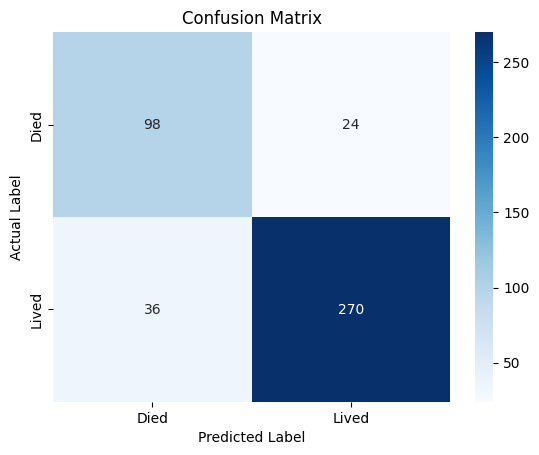

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Died', 'Lived'], yticklabels=['Died', 'Lived'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

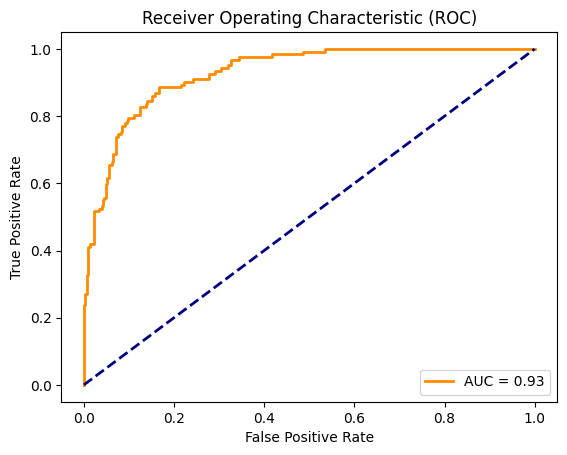

In [24]:
# ROC curve with AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# GitHub

Check out this notebook in [my GitHub repo](https://github.com/coreymichaud/predicting-aids-deaths), where I have a detailed .README writeup.